In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()

In [3]:
len(words)

32658

In [4]:
# build vocab of characters and mappings to / from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'ó', 28: 'ę', 29: 'ł', 30: 'ń', 31: 'ś', 32: 'ż', 0: '.'}
33


In [5]:
import random
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))  
n2 = int(0.9 * len(words))
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [31]:
# MLP code from last project
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) #Kaiming initialization
b1 = torch.randn(n_hidden, generator=g) * 0.01 # b1 is small at initialization
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # W2 is small at initialization
b2 = torch.randn(vocab_size, generator=g) * 0 # b2 is zero at initialization

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad_()

13563


In [32]:
# training loop
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # create minibatch
    ix = torch.randint(0, Xtrain.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias # batch normalization

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 1000 == 0:
        lossi.append(loss.item())
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/ 200000: 3.4966
   1000/ 200000: 2.2863
   2000/ 200000: 2.1032
   3000/ 200000: 2.2115
   4000/ 200000: 2.3798
   5000/ 200000: 2.4021
   6000/ 200000: 2.2208
   7000/ 200000: 2.5282
   8000/ 200000: 2.3365
   9000/ 200000: 2.6579
  10000/ 200000: 2.2455
  11000/ 200000: 2.2142
  12000/ 200000: 2.0478
  13000/ 200000: 1.8891
  14000/ 200000: 2.3769
  15000/ 200000: 2.4665
  16000/ 200000: 2.4384
  17000/ 200000: 2.3814
  18000/ 200000: 2.0763
  19000/ 200000: 2.1609
  20000/ 200000: 2.1901
  21000/ 200000: 2.1840
  22000/ 200000: 2.1454
  23000/ 200000: 2.1840
  24000/ 200000: 1.9814
  25000/ 200000: 2.0532
  26000/ 200000: 1.7022
  27000/ 200000: 2.0667
  28000/ 200000: 2.3880
  29000/ 200000: 2.0548
  30000/ 200000: 2.5400
  31000/ 200000: 2.2356
  32000/ 200000: 1.8880
  33000/ 200000: 2.2501
  34000/ 200000: 2.4753
  35000/ 200000: 2.4593
  36000/ 200000: 2.0303
  37000/ 200000: 2.3009
  38000/ 200000: 2.5813
  39000/ 200000: 2.1002
  40000/ 200000: 2.2897
  41000/ 200000:

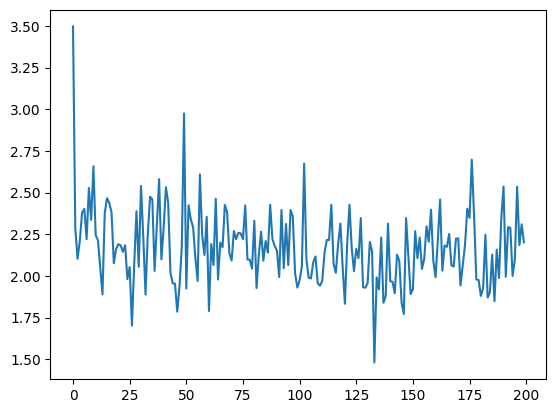

In [26]:
plt.plot(lossi)

In [27]:
# I already implemented it in straining stage using running mean and std

# # calibrating batch normalization after training loop

# with torch.no_grad():
#     emb = C[Xtrain]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     # measure mean and std over entire training set
#     bnmean = hpreact.mean(dim=0, keepdim=True)
#     bnstd = hpreact.std(dim=0, keepdim=True)

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias # batch normalization
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.075850009918213
dev 2.117523431777954


In [35]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias # batch normalization
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out[:-1]))

junide
jakarie
presay
adria
jirrito
sabe
ter
kalinaa
zamilena
jededailewintlessia
evy
arterinvellerin
demmerickysie
hesandreora
yarion
kaelandreed
mikimbynin
anaasnessiah
mazah
dion
